In [1]:
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
import pandas as pd
from time import sleep
import json
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

## Task 1: Data Cleaning and Exploration

### 1.1 Web Scraping

Write a script to extract data from the Office for Civil Rights breach reports available at this URL: https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf.
Your script should extract all fields available for each reported breach (including historical data). The fields may include 'Name of Covered Entity', 'State', 'Covered Entity Type', 'Individuals Affected', 'Breach Submission Date', 'Type of Breach', 'Location of Breached Information', 'Business Associate Present', 'Web Description' etc.

In [2]:
# Chromedriver initialization

browser = Chrome('/Users/viktorzumahmetov/Desktop/chromedriver')

/var/folders/1b/0hr3g4g90b18klv4w9h693_w0000gn/T/ipykernel_16137/1857961044.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = Chrome('/Users/viktorzumahmetov/Desktop/chromedriver')


In [3]:
# Open webpage in browser

url = 'https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf'
browser.get(url)
sleep(5)

In [4]:
# Collecting data from all 9 pages using Selenium and BS4 

data = []

for _ in range(10):
    soup = BeautifulSoup(browser.page_source, 'html')
    table = soup.find('tbody',class_='ui-datatable-data ui-widget-content')
    rows = table.findAll('tr', role='row')
    filtered_rows = [row.findAll('td', role='gridcell')[1:] for row in rows if 'column' not in str(row)]
    for row in filtered_rows:
        name_of_covered_entity = row[0].text.strip()
        state = row[1].text.strip()
        covered_entity_type = row[2].text.strip()
        individuals_affected = row[3].text.strip()
        breach_submission_date = row[4].text.strip()
        type_of_breach = row[5].text.strip()
        location_of_breached_information = row[6].text.strip()
        business_associate_present = row[7].text.strip()
        web_description = row[8].text.strip()
        data.append([name_of_covered_entity,state,covered_entity_type,
                     individuals_affected,breach_submission_date,
                     type_of_breach,location_of_breached_information,
                     business_associate_present,web_description])
        
    next_page_button = browser.find_element(By.XPATH,'//*[@id="ocrForm:reportResultTable_paginator_bottom"]/a[3]/span')
    next_page_button.click()
    sleep(5)

In [5]:
# Data transformation to Pandas DataFreame

df = pd.DataFrame(data, columns =['name_of_covered_entity','state','covered_entity_type','individuals_affected','breach_submission_date','type_of_breach','location_of_breached_information','business_associate_present','web_description'])
df.head()

,name_of_covered_entity,state,covered_entity_type,individuals_affected,breach_submission_date,type_of_breach,location_of_breached_information,business_associate_present,web_description
0,Fertility Specialists Medical Group,CA,Healthcare Provider,9437,05/15/2023,Hacking/IT Incident,Network Server,No,
1,Lehigh Valley Health Network,PA,Healthcare Provider,627,05/15/2023,Hacking/IT Incident,Network Server,No,
2,R&B Corporation of Virginia d/b/a Credit Contr...,VA,Business Associate,345523,05/13/2023,Hacking/IT Incident,Network Server,Yes,
3,Illinois Department of Healthcare and Family S...,IL,Health Plan,50839,05/12/2023,Hacking/IT Incident,Network Server,No,
4,Solutran,MN,Business Associate,17728,05/12/2023,Hacking/IT Incident,Network Server,Yes,


In [6]:
# Checking for duplicated rows

df.duplicated().sum()

65

In [7]:
# Deleting duplicated rows and checking final DataFrame size

df.drop_duplicates(inplace=True)
df.shape

(865, 9)

In [8]:
# Checking data types

df.dtypes

name_of_covered_entity              object
state                               object
covered_entity_type                 object
individuals_affected                object
breach_submission_date              object
type_of_breach                      object
location_of_breached_information    object
business_associate_present          object
web_description                     object
dtype: object

In [9]:
# Wrong types formatting

df['individuals_affected'] = df['individuals_affected'].astype('int')

### 1.2 Data Formatting

For each reported breach, create a separate JSON file. The JSON file should be properly structured to match the fields obtained from the breach reports.

Also add custom JSON metadata to insert custom data per the below:
1. Add “Date_Scraped” – Insert the current date/time
2. Add “Category: OCR_Breaches_Archive or OCR_Breaches_Current
This will be dependent on which dataset you are outputting at that time.


In [10]:
# Writing each row in individual JSON file with added features

for index, row in df.iterrows():

    report_data = row.to_dict()
    report_data['date_scraped'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    report_data['category'] = 'OCR_Breaches_Archive'

    json_data = json.dumps(report_data, indent=4)

    with open(f'breach_{index}.json', 'w') as json_file:
       json_file.write(json_data)

### 1.3 Data Validation 

Write a function to validate the structured JSON data. This function should check that all expected fields are present, and that the values are of the correct type.


In [11]:
# JSON validation function

def validate_json(json_data, expected_fields):
    # Load the JSON data
    try:
        data = json.loads(json_data)
    except json.JSONDecodeError:
        return False, "Invalid JSON"

    # Check the presence of expected fields
    missing_fields = set(expected_fields) - set(data.keys())
    if missing_fields:
        return False, f"Missing fields: {', '.join(missing_fields)}"

    # Check the types of the fields
    for field, expected_type in expected_fields.items():
        actual_type = type(data[field])
        if actual_type != expected_type:
            return False, f"Invalid type for field '{field}': Expected {expected_type}, got {actual_type}"

    return True, "JSON is valid"

In [12]:
# Expected fields and their types for validation

expected_fields = {
    'name_of_covered_entity': str,
    'state': str,
    'covered_entity_type': str,
    'individuals_affected': int,
    'breach_submission_date': str,
    'type_of_breach': str,
    'location_of_breached_information': str,
    'business_associate_present': str,
    'web_description': str,
    'date_scraped': str,
    'category': str
}

In [13]:
# Validation testing

validate_json(json_data, expected_fields)

(True, 'JSON is valid')

## Task 2: Data Visualization + Task 3: Statistical Analysis

Create meaningful visualizations from the data collected. You may use libraries like Matplotlib, Seaborn, Plotly, etc. for this task.
You can export your data output into a visualization program like Tableau, etc as well. (Please choose whichever you feel promotes your strongest skills)
Keep in mind that the audience for these visualizations is a group of managers who are interested in detailed insights, not high-level summaries.

For instance, you can create visualizations that answer questions like: Which states have the most reported breaches? What types of breaches are most common? How has the number of breaches changed over time? What types of entities are most often involved in breaches?

/var/folders/1b/0hr3g4g90b18klv4w9h693_w0000gn/T/ipykernel_16137/2630960547.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['STATE_ABBR']):


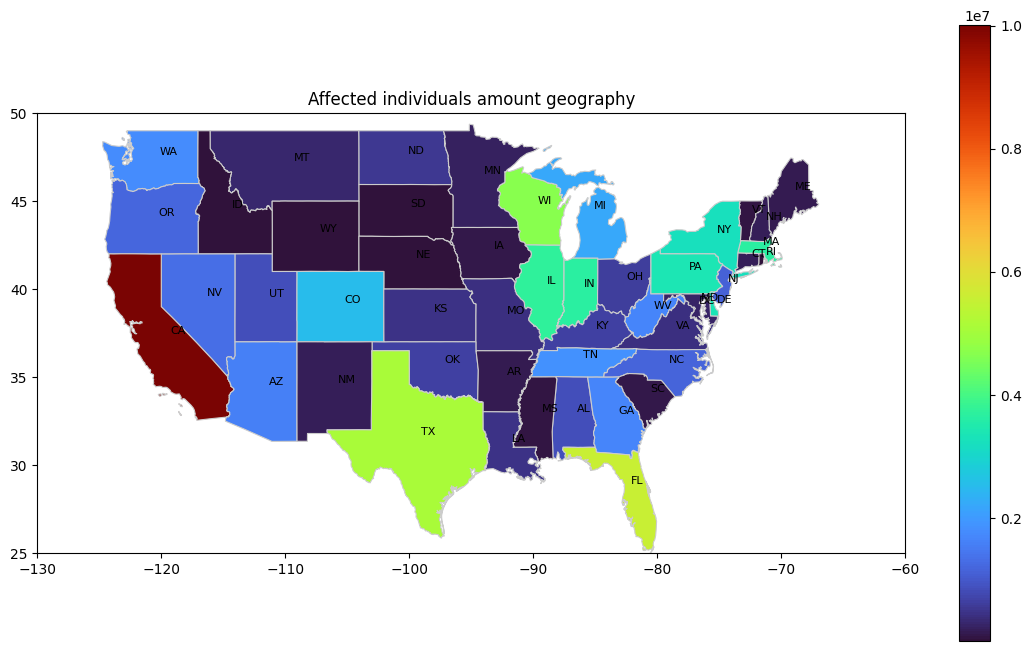

In [14]:
# Creating USA map with states borders using geopandas and pre-loaded file with required geographical data to show affected individuals amount heatmap by state.

states_data = gpd.read_file('USA_States.shp')
df_geo = df.groupby('state',as_index=False).agg({'individuals_affected':'sum'})[1:]
merged = states_data.merge(df_geo, left_on='STATE_ABBR', right_on='state', how='left')


fig,ax = plt.subplots(figsize=(14, 8))
merged.plot(column='individuals_affected', cmap='turbo', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
for x, y, label in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged['STATE_ABBR']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)
plt.title('Affected individuals amount geography')
plt.xlim(-130,-60)
plt.ylim(25,50)
plt.show()

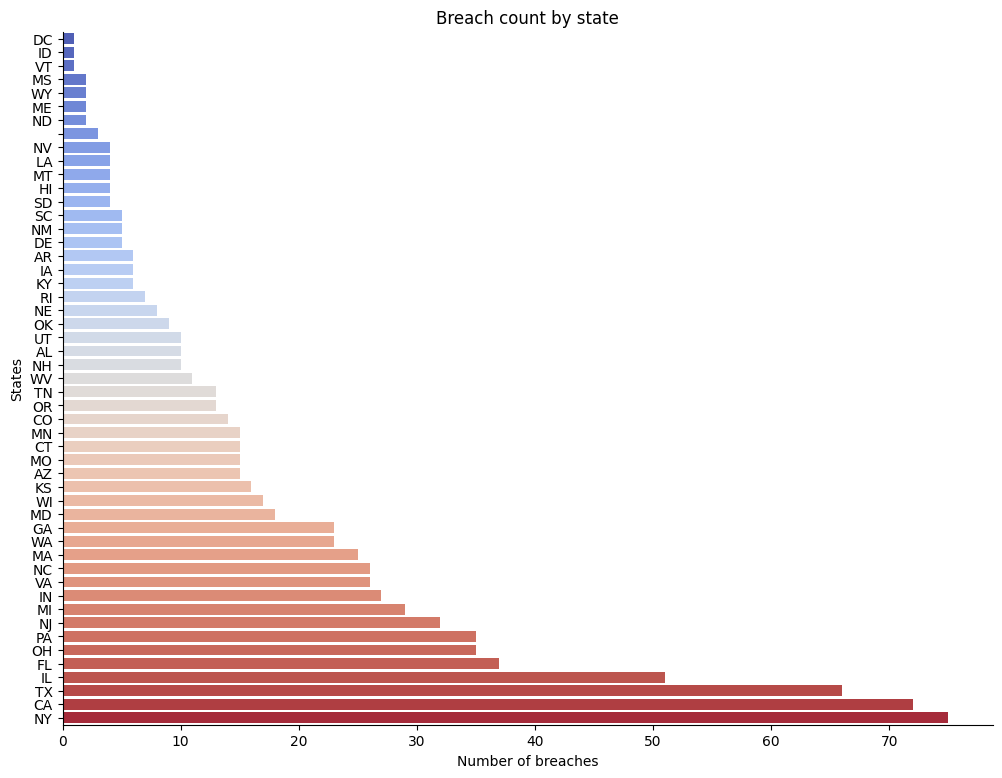

In [15]:
# Breach count by state.

plt.figure(figsize=(12,9))
sns.countplot(data = df, y = 'state', order =reversed(df.state.value_counts().index), palette = 'coolwarm')
plt.title('Breach count by state')
plt.xlabel('Number of breaches')
plt.ylabel('States')
sns.despine()
plt.show()

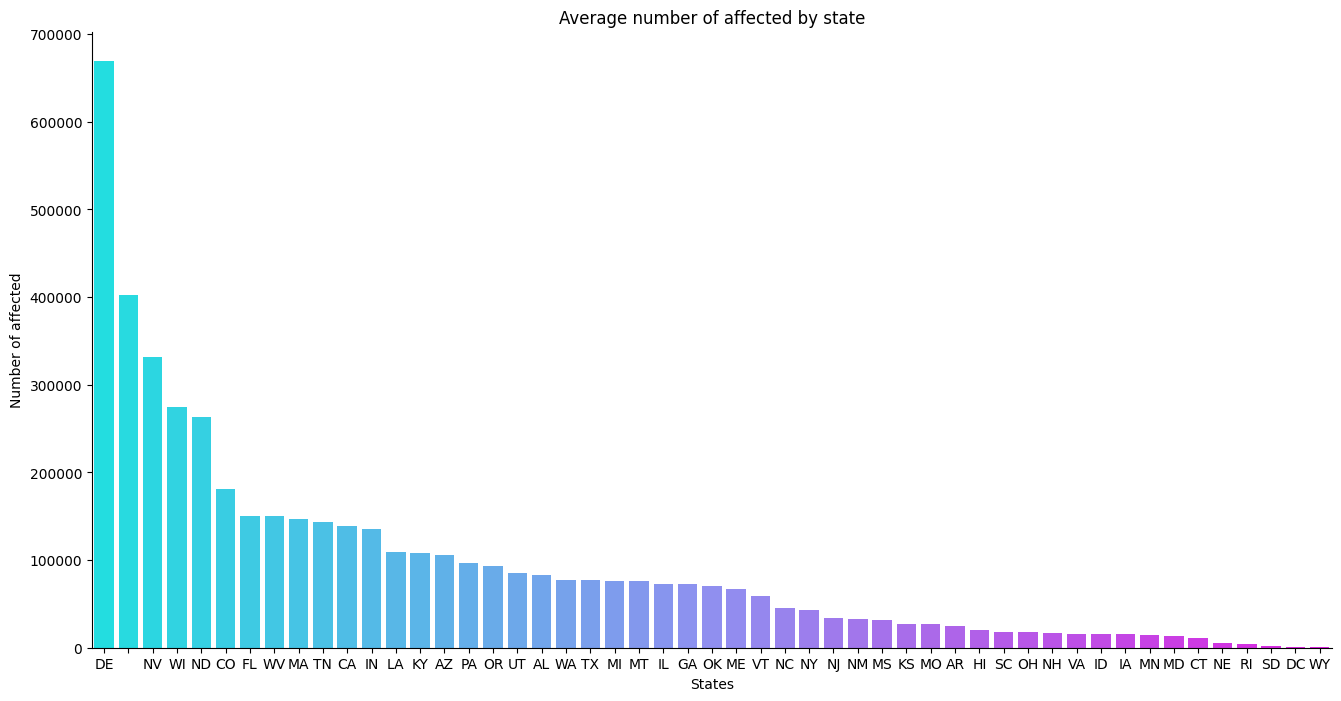

In [16]:
# Average number of affected by state.

avg_affected_by_state = df.groupby('state', as_index=False).agg({'individuals_affected':'mean'}).sort_values('individuals_affected', ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(data = avg_affected_by_state, x='state', y='individuals_affected', palette='cool')
plt.title('Average number of affected by state')
plt.ylabel('Number of affected')
plt.xlabel('States')
sns.despine()
plt.show()

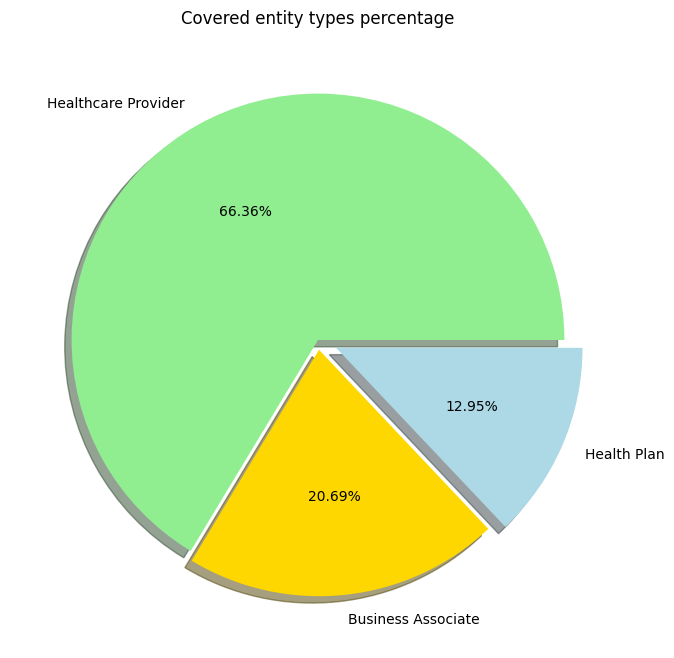

In [17]:
# Covered entity types percentage.

plt.figure(figsize = (8,8))
df.covered_entity_type.value_counts().plot.pie(autopct='%1.2f%%', shadow = True, explode = [0,0.04,0.08], colors = ['lightgreen','gold','lightblue'])
plt.title('Covered entity types percentage')
plt.ylabel('')
plt.show()

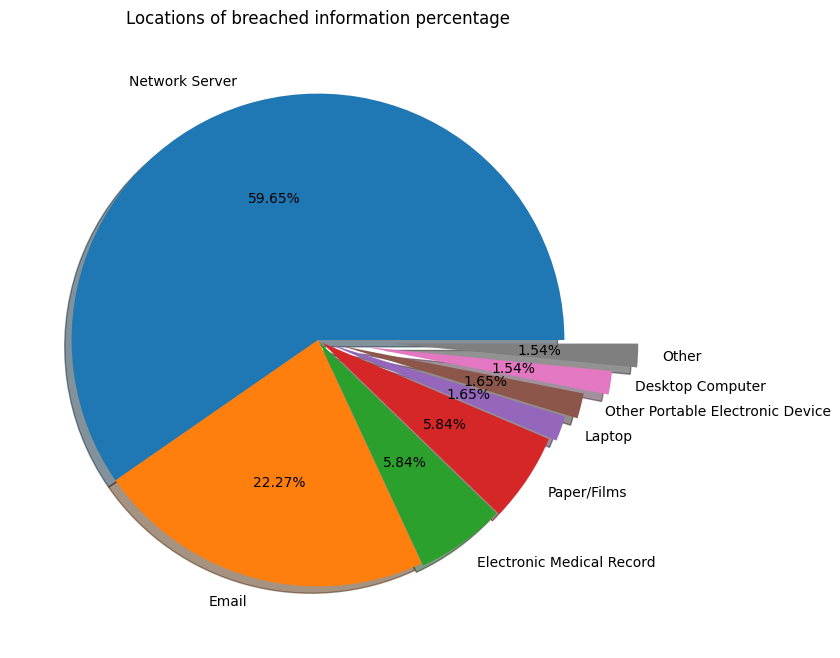

In [18]:
# Locations of breached information percentage.

locations_exploded = df.location_of_breached_information.apply(lambda x: x.split(', ')).explode()

plt.figure(figsize=(8,8))
locations_exploded.value_counts().plot.pie(autopct='%1.2f%%', shadow = True, explode=[0,0,0.01,0.02,0.05,0.1,0.2,0.3])
plt.title('Locations of breached information percentage')
plt.ylabel('')
plt.show()

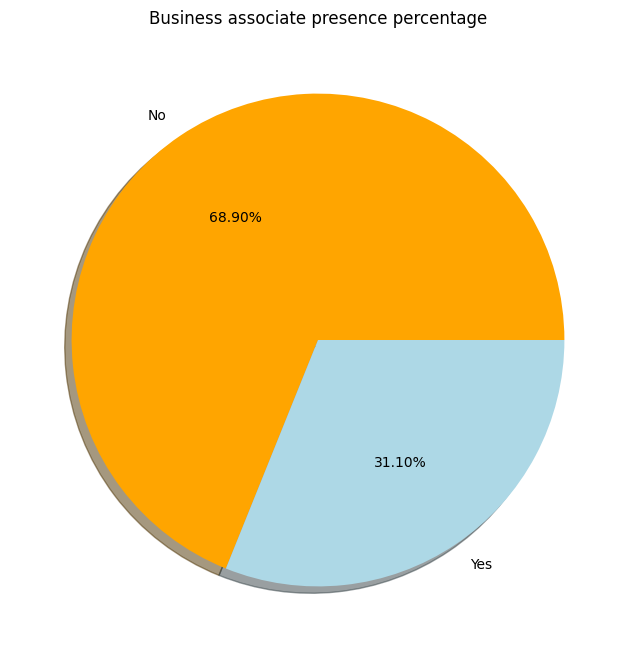

In [19]:
# Business associate presence percentage.

plt.figure(figsize=(8,8))
df.business_associate_present.value_counts().plot.pie(autopct='%1.2f%%', shadow = True, colors=['orange','lightblue'])
plt.title('Business associate presence percentage')
plt.ylabel('')
plt.show()

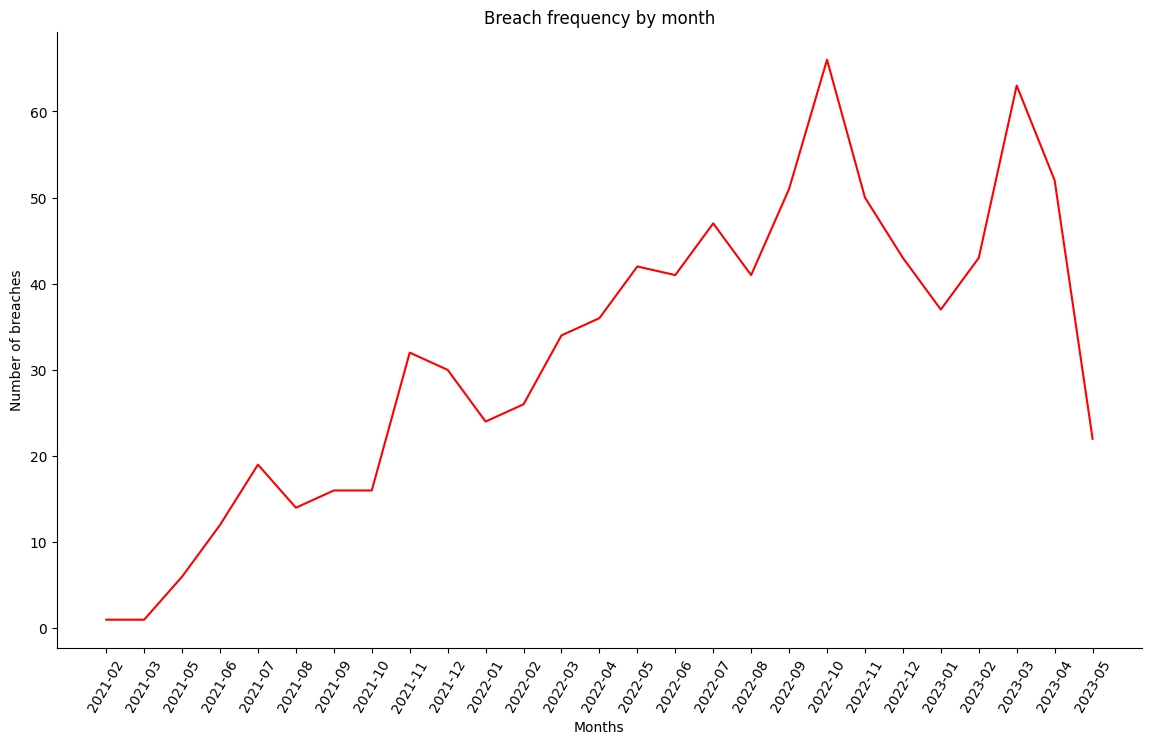

In [20]:
# Breach frequency by month.
df['breach_submission_date'] = pd.to_datetime(df['breach_submission_date'])
df['year_month']=df['breach_submission_date'].astype(str).apply(lambda x: x[:-3])

plt.figure(figsize=(14,8))
sns.lineplot(df['year_month'].value_counts().sort_index(ascending=True), color='red')
plt.xticks(rotation=60)
plt.title('Breach frequency by month')
plt.xlabel('Months')
plt.ylabel('Number of breaches')
sns.despine()
plt.show()

In [21]:
# Total number of affected individuals

affected_total_number = df.individuals_affected.sum()
affected_total_number

73532209

## Task 4: Communication

* Summarize your findings from the previous tasks in a brief report or presentation format.
* Include key insights and visualizations.

### Data analysis report

* New York, California and Texas are states with the largest breaches amount among all 50 states.
* California has maximum total number of affected.
* But Delaware has largest average number of affected individuals.
* Overal breach activity has two large peaks in 2022.10 and 2023.03.
* 2021.02 and 2021.03 are most successful months by breach activity.
* Network Server - the most common location of breached information (59.56%).
* Helthcare Provider is most frequent entity type (66.5%).
* The largest part does not have a business associate (68.9%).
* Historical data includes dates from 2021-02 to 2023-05.
* 73,541,249 is total number of affected individuals.
